In [14]:
%pip install numpy torch matplotlib gymnasium stable_baselines3 "gymnasium[other]" "gymnasium[classic_control]"

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
    --------------------------------------- 0.3/10.6 MB ? eta -:--:--
   -------------- ------------------------- 3.9/10.6 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 27.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт и подготовка окружения
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym

from matplotlib import animation
from IPython.display import HTML
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, ProgressBarCallback
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import RecordVideo
import os


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Эксперимент 1

Гипотеза: PPO будет обучаться стабильнее и получать бóльшую среднюю награду, чем A2C

In [3]:
env_id = "Pendulum-v1"

# Создаём векторизованную среду
ppo_train_env = DummyVecEnv([lambda: Monitor(gym.make(env_id))])
a2c_train_env = DummyVecEnv([lambda: Monitor(gym.make(env_id))])

ppo_eval_env = DummyVecEnv([lambda: Monitor(gym.make(env_id))])
a2c_eval_env = DummyVecEnv([lambda: Monitor(gym.make(env_id))])

In [4]:
ppo_eval_callback = EvalCallback(
    ppo_eval_env,
    eval_freq=10_000,
    n_eval_episodes=20,
    verbose=0,
    deterministic=True,
    render=False,
    best_model_save_path=None,
    log_path="./logs_ppo/"
)

a2c_eval_callback = EvalCallback(
    a2c_eval_env,
    eval_freq=10_000,
    n_eval_episodes=20,
    verbose=0,
    deterministic=True,
    render=False,
    best_model_save_path=None,
    log_path="./logs_a2c/"
)

In [5]:
# обучение PPO
model_ppo = PPO(
    "MlpPolicy",
    ppo_train_env,
    verbose=0,
    seed=SEED,
    device='cpu'
)

model_ppo.learn(total_timesteps=500_000, callback=ppo_eval_callback)

In [6]:
# Обучение A2C
model_a2c = A2C(
    "MlpPolicy",
    a2c_train_env,
    verbose=0,
    seed=SEED,
    device='cpu'
)
model_a2c.learn(total_timesteps=500_000, callback=a2c_eval_callback)

In [7]:
eval_env = DummyVecEnv([lambda: Monitor(gym.make(env_id))])

# Оценка PPO
mean_reward_ppo, std_reward_ppo = evaluate_policy(model_ppo, eval_env, n_eval_episodes=20)
print(f"PPO: {mean_reward_ppo:.2f} ± {std_reward_ppo:.2f}")

# Оценка A2C
mean_reward_a2c, std_reward_a2c = evaluate_policy(model_a2c, eval_env, n_eval_episodes=20)
print(f"A2C: {mean_reward_a2c:.2f} ± {std_reward_a2c:.2f}")


PPO: -203.91 ± 118.41
A2C: -832.82 ± 544.29


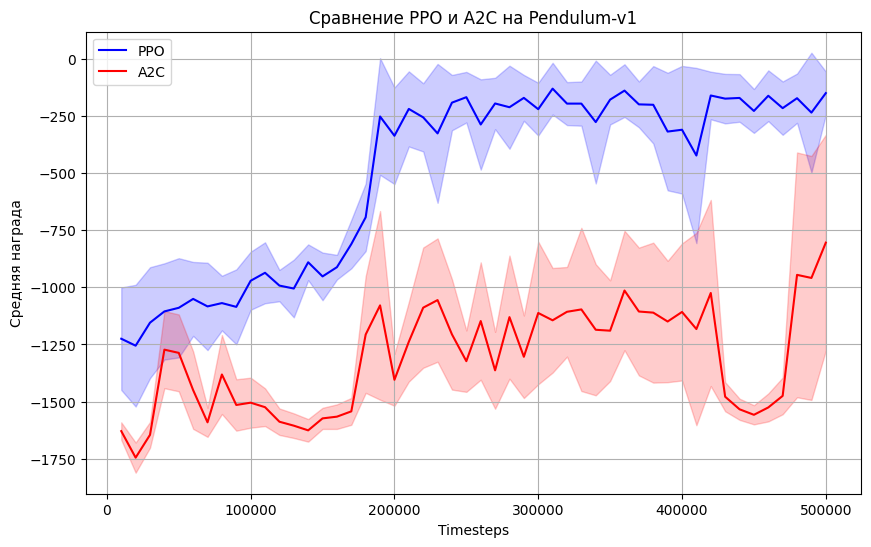

In [8]:
ppo_data = np.load("./logs_ppo/evaluations.npz")
ppo_timesteps = ppo_data["timesteps"]
ppo_mean_rewards = ppo_data["results"].mean(axis=1)
ppo_std_rewards = ppo_data["results"].std(axis=1)

a2c_data = np.load("./logs_a2c/evaluations.npz")
a2c_timesteps = a2c_data["timesteps"]
a2c_mean_rewards = a2c_data["results"].mean(axis=1)
a2c_std_rewards = a2c_data["results"].std(axis=1)

plt.figure(figsize=(10,6))
plt.plot(ppo_timesteps, ppo_mean_rewards, label="PPO", color="blue")
plt.fill_between(ppo_timesteps, ppo_mean_rewards-ppo_std_rewards, ppo_mean_rewards+ppo_std_rewards, color="blue", alpha=0.2)

plt.plot(a2c_timesteps, a2c_mean_rewards, label="A2C", color="red")
plt.fill_between(a2c_timesteps, a2c_mean_rewards-a2c_std_rewards, a2c_mean_rewards+a2c_std_rewards, color="red", alpha=0.2)

plt.xlabel("Timesteps")
plt.ylabel("Средняя награда")
plt.title("Сравнение PPO и A2C на Pendulum-v1")
plt.legend()
plt.grid(True)
plt.show()


Гипотеза оказалась верна: PPO обучается стабильнее и получает бóльшую среднюю награду, чем A2C

# Эксперимент 2

Гипотеза: более низкий gamma (0.9) заставит агента планировать более краткосрочно, что уменьшит награду

In [9]:
gammas = [0.9, 0.99]
results = {}

for g in gammas:
    exp_env = DummyVecEnv([lambda: Monitor(gym.make("Pendulum-v1"))])
    eval_env = DummyVecEnv([lambda: Monitor(gym.make("Pendulum-v1"))])
    
    model_g = PPO(
        "MlpPolicy",
        exp_env,
        gamma=g,
        seed=SEED,
        verbose=0,
        device='cpu'
    )

    eval_callback = EvalCallback(
        eval_env,
        eval_freq=10_000,
        n_eval_episodes=20,
        verbose=0,
        deterministic=True,
        render=False,
        best_model_save_path=None,
        log_path=f"./logs_ppo_{int(g * 100)}/"
    )
    
    model_g.learn(total_timesteps=500_000, callback=eval_callback)
    mean_reward, _ = evaluate_policy(model_g, exp_env, n_eval_episodes=20)
    results[g] = mean_reward

print("Средние награды по gamma:", results)

Средние награды по gamma: {0.9: np.float64(-177.2468287), 0.99: np.float64(-155.28506629999998)}


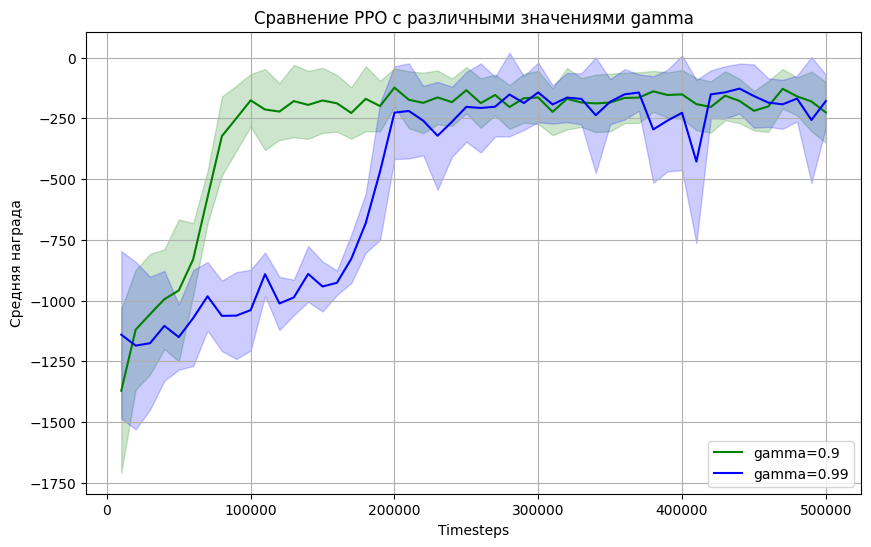

In [10]:
plt.figure(figsize=(10,6))
colors = iter(['green', 'blue', 'red'])

for g in gammas:
    ppo_data = np.load(f"./logs_ppo_{int(g * 100)}/evaluations.npz")
    ppo_timesteps = ppo_data["timesteps"]
    ppo_mean_rewards = ppo_data["results"].mean(axis=1)
    ppo_std_rewards = ppo_data["results"].std(axis=1)
    
    color = next(colors)
    plt.plot(ppo_timesteps, ppo_mean_rewards, label=f"gamma={g}", color=color)
    plt.fill_between(ppo_timesteps, ppo_mean_rewards-ppo_std_rewards, ppo_mean_rewards+ppo_std_rewards, color=color, alpha=0.2)

plt.xlabel("Timesteps")
plt.ylabel("Средняя награда")
plt.title("Сравнение PPO с различными значениями gamma")
plt.legend()
plt.grid(True)
plt.show()


Гипотеза оказалась неверна: gamma = 0.9 гораздо быстрее сошелся и имеет практически ту же награду. Также стандартные отклонения почти на всех участках меньше

# Визуализация агента (сохранение в videos)

In [15]:
video_dir = "./videos"
os.makedirs(video_dir, exist_ok=True)

render_env = gym.make("Pendulum-v1", render_mode="rgb_array")

render_env = RecordVideo(
    render_env,
    video_folder=video_dir,
    episode_trigger=lambda episode_id: True,  # записывать каждый эпизод
    name_prefix="ppo_pendulum"
)

obs, _ = render_env.reset(seed=SEED)
done = False

while not done:
    action, _ = model_ppo.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated

render_env.close()


C:\ProgramData\anaconda3\envs\test\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


# Выводы

 Подтвердилась первая гипотеза: PPO будет обучаться стабильнее и получать бóльшую среднюю награду, чем A2C. Скорее всего A2C делает слишком большие обновления (особенно в непрерывной среде), чего PPO избегает благодаря клиппингу ratio.

Опроверглась вторая гипотеза: "более низкий gamma (0.9) заставит агента планировать более краткосрочно, что уменьшит награду". Оба варианта сходятся к одному поведению, разница в скорости и стабильности. Поскольку награда локальная, без отсроченных бонусов, возможно минимизировать ошибку прямо сейчас выгоднее.